<a href="https://colab.research.google.com/github/ArmandoSep/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- [**pdpbox**](https://github.com/SauceCat/PDPbox)
- plotly
- scikit-learn
- scipy.stats
- [**shap**](https://github.com/slundberg/shap)
- xgboost


In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# Visualize and interpret partial dependence plots

## Overview

Partial dependence plots show the relationship between 1-2 individual features and the target — how predictions partially depend on the isolated features.

It's explained well by [PDPbox library documentation](https://pdpbox.readthedocs.io/en/latest/):

>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.


Let's also look at an [animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples):

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)


To demonstrate, we'll use a Lending Club dataset, to predict interest rates. (Like [this example](https://rrherr-project2-example.herokuapp.com/).)

In [0]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history = history.dropna()

# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

In [0]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


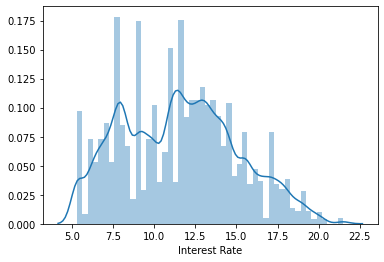

In [4]:
# The target has some right skew, but it's not too bad
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [5]:
y_train.mean()

11.562291125592306

### Fit Linear Regression model

In [6]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.22422462337805615


### Explaining Linear Regression

In [7]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Annual Income   -0.000003
Credit Score    -0.052736
Loan Amount      0.000018
Loan Purpose     1.000816
Monthly Debts   -0.000021
dtype: float64

In [9]:
X_train.describe()

,Annual Income,Credit Score,Loan Amount,Monthly Debts
count,8.162800e+04,81628.000000,81628.000000,81628.000000
mean,7.471581e+04,700.098410,12681.827927,1017.141284
std,7.942272e+04,31.657567,7992.222117,713.277866
min,7.000000e+02,664.000000,500.000000,0.000000
25%,4.500000e+04,674.000000,6625.000000,547.050000
50%,6.208400e+04,694.000000,10000.000000,869.916667
75%,9.000000e+04,714.000000,16800.000000,1313.020833
max,9.000000e+06,850.000000,40000.000000,23951.250000


In [12]:
X_train['Loan Purpose'].value_counts()[:15]

Debt consolidation         38419
Credit card refinancing    16419
Home improvement            4159
Other                       3824
Major purchase              1409
Debt Consolidation          1079
Medical expenses             849
Car financing                735
Business                     627
Vacation                     477
Moving and relocation        461
debt consolidation           358
Consolidation                328
Debt Consolidation Loan      245
Home buying                  198
Name: Loan Purpose, dtype: int64

### Fit Gradient Boosting model


In [13]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.27488377264062747


### Explaining Gradient Boosting???

Linear models have coefficients, but trees do not.

Instead, to see the relationship between individual feature(s) and the target, we can use partial dependence plots.

## Follow Along


### Partial Dependence Plots with 1 feature

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)


In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Annual Income'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features = X_val.columns,
    feature=feature
)

In [17]:
isolated

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


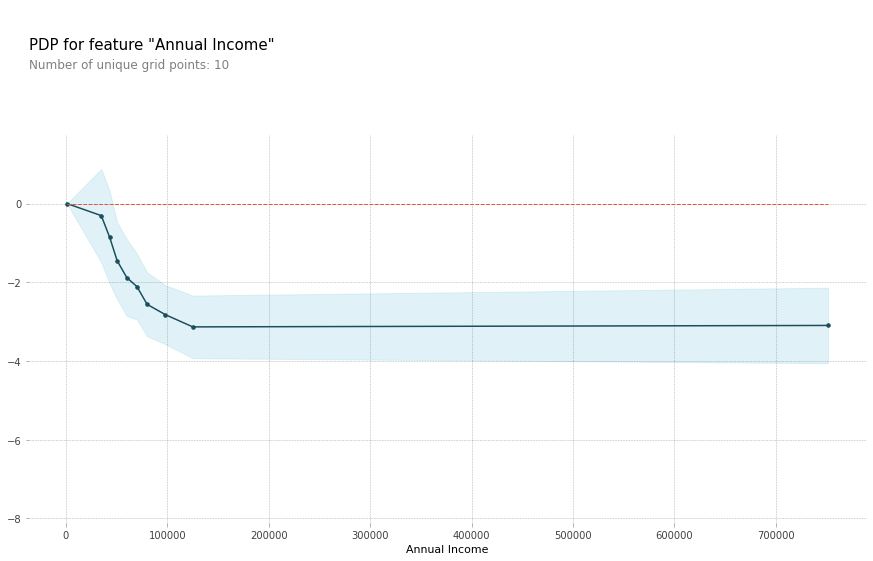

In [18]:
pdp_plot(isolated, feature_name=feature);

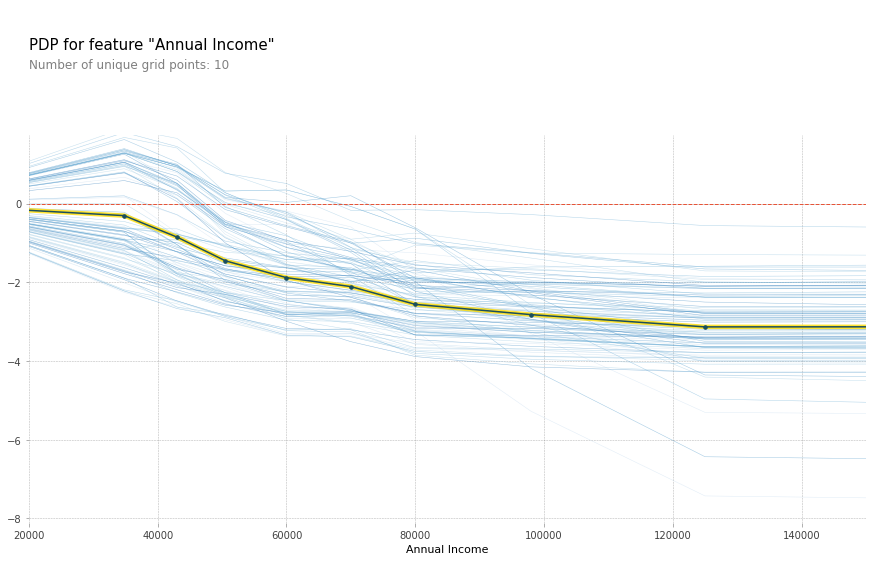

In [20]:
# One other way to visualize this = add ICE curves
# ICE - individual Condition Expectation
import matplotlib.pyplot as plt


pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)
plt.xlim((20000, 150000));

In [0]:
# We can use more grid points

isolated = pdp_isolate(
    model = gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=50
)

In [23]:
# How many predictions did iy have to make?
len(X_val) * 50

500000

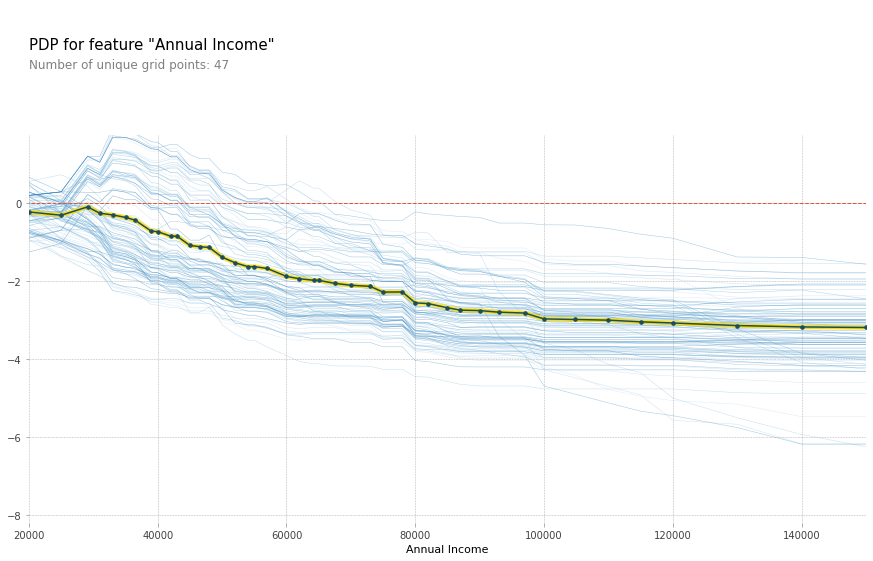

In [24]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)
plt.xlim((20000, 150000));

### Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20 with some versions of matplotlib:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40


In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interaction = pdp_interact(
    model = gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6e5dd3fa90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6e5e5b4da0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


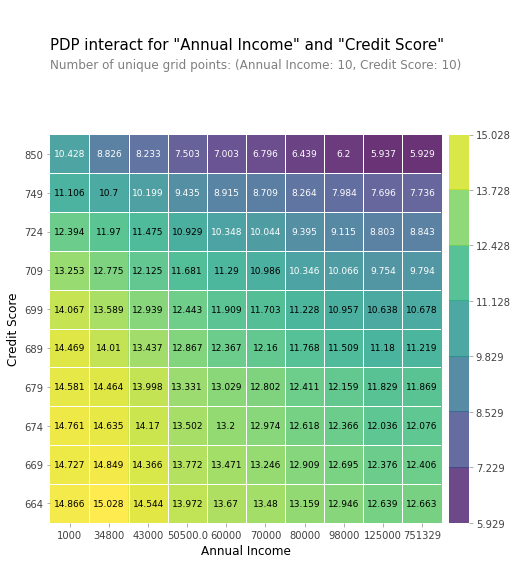

In [27]:
# Shows the interest rate output, not the change. 
# Color = target -> interest rate

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features)

### BONUS: 3D with Plotly!

Just for your future reference, here's how you can make it 3D! (Like [this example](https://rrherr-project2-example.herokuapp.com/).)

In [0]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

In [0]:
pdp = pdp.drop(columns=[1000.0, 751329.0])

In [30]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### BONUS: PDPs with categorical features

Just for your future reference, here's a bonus example to demonstrate partial dependence plots with categorical features.

1. I recommend you use Ordinal Encoder or Target Encoder, outside of a pipeline, to encode your data first. (If there is a natural ordering, then take the time to encode it that way, instead of random integers.) Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.


In [31]:
# Fit a model on Titanic data
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = sns.load_dataset('titanic')
df.age = df.age.fillna(df.age.median())
df = df.drop(columns='deck')
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

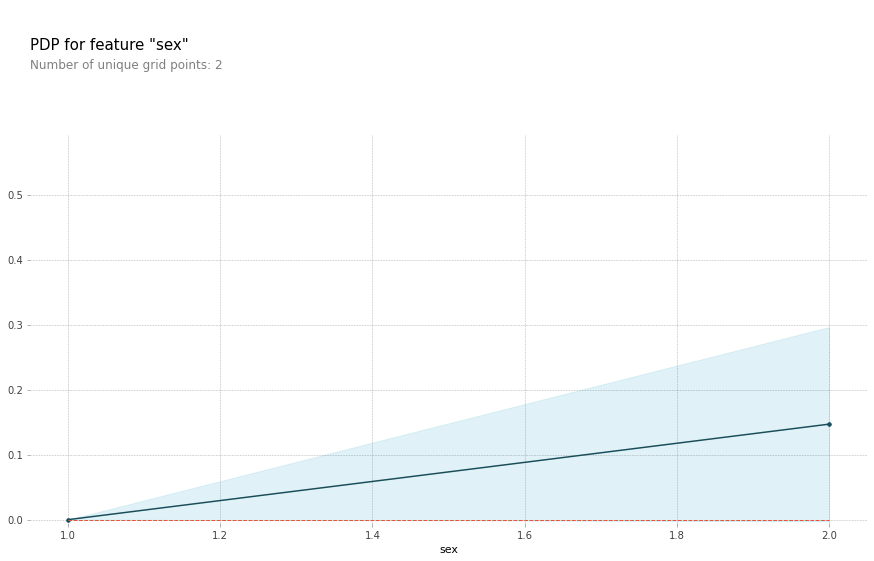

In [32]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [33]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'sex', 'data_type': dtype('O'), 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64},
 {'col': 'embarked', 'data_type': dtype('O'), 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64},
 {'col': 'class',
  'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False),
  'mapping': Third     1
  First     2
  Second    3
  NaN      -2
  dtype: int64},
 {'col': 'who', 'data_type': dtype('O'), 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64},
 {'col': 'embark_town', 'data_type': dtype('O'), 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64}]

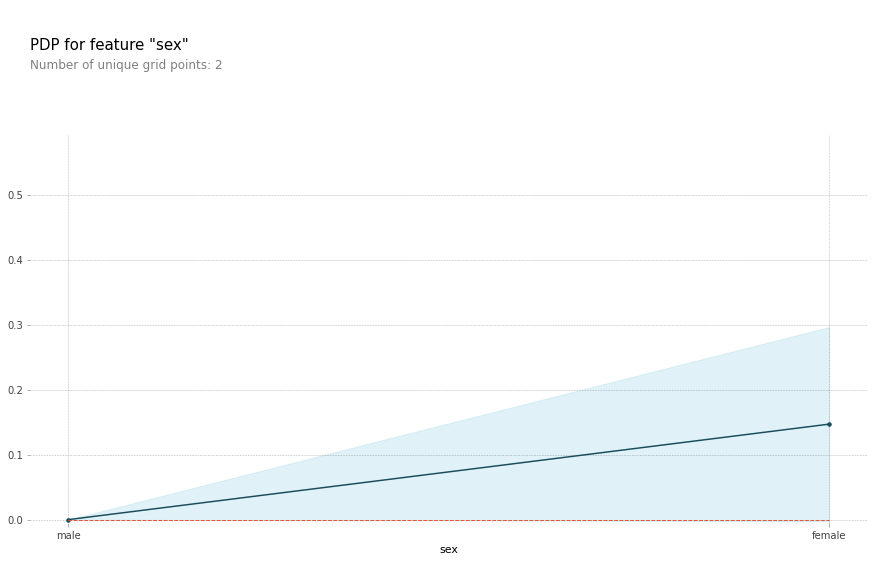

In [34]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([1, 2], ['male', 'female']);

In [0]:
# Let's automate it

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

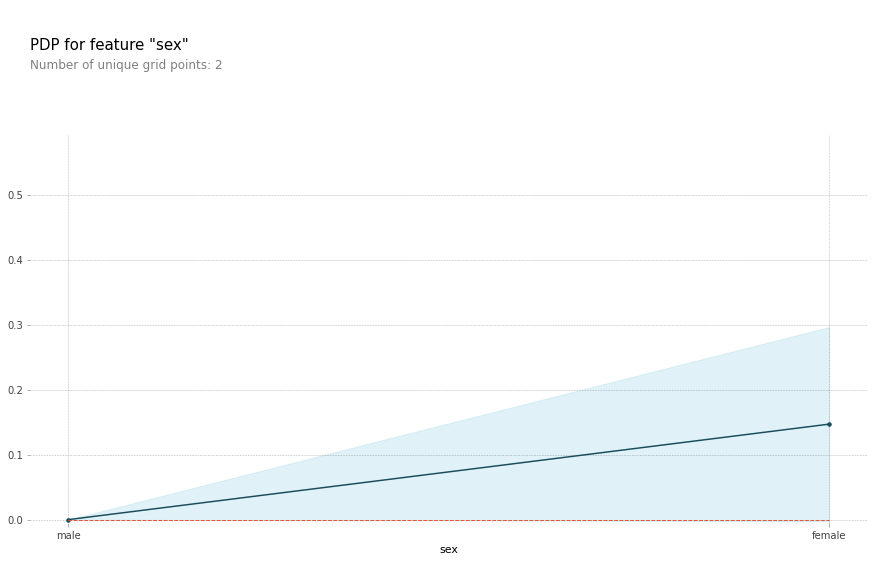

In [36]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

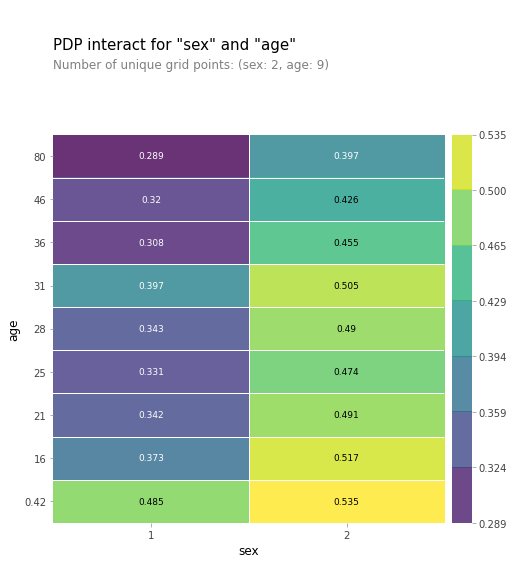

In [37]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

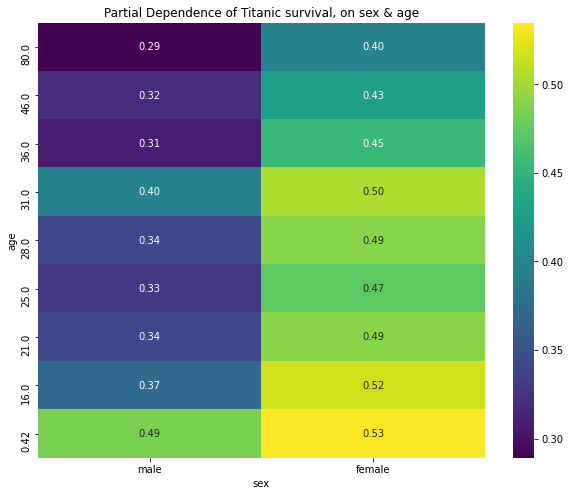

In [38]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Titanic survival, on sex & age');

# Explain individual predictions with shapley value plots

## Overview

We’ll use TreeExplainer from an awesome library called [SHAP](https://github.com/slundberg/shap), for “additive explanations” — we can explain individual predictions by seeing how the features add up!

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png" width="800" />

### Regression example

We're coming full circle, with the NYC Apartment Rent dataset! Remember this code you wrote for your first assignment?

```python
# Arrange X features matrix & y target vector
features = ['bedrooms', 'bathrooms']
target = 'price'
X = df[features]
y = df[target]

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

def predict(bedrooms, bathrooms):
    y_pred = model.predict([[bedrooms, bathrooms]])
    estimate = y_pred[0]
    bed_coef = model.coef_[0]
    bath_coef = model.coef_[1]
    
    # Format with $ and comma separators. No decimals.
    result = f'Rent for a {bedrooms}-bed, {bathrooms}-bath apartment in NYC is estimated at ${estimate:,.0f}.'
    explanation = f' In this model, each bedroom adds ${bed_coef:,.0f} & each bathroom adds ${bath_coef:,.0f}.'
    return result + explanation
```

Let’s do something similar, but with a tuned Random Forest and Shapley Values.

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

In [0]:
# Assign to X, y
features = ['bedrooms', 'bathrooms', 'longitude', 'latitude']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [41]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.2s finished


In [42]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 201}
Cross-validation MAE 375.95637690332126


## Follow Along

#### [Dan Becker explains Shapley Values:](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?
>
>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 
>
>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [44]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.

row = X_test.iloc[[0]] # Double brackets to return a dataframe
row

,bedrooms,bathrooms,longitude,latitude
0,3,1.5,-73.9425,40.7145


In [45]:
# What was the actual rent for this apartment?
y_test.iloc[[0]]

0    3000
Name: price, dtype: int64

In [46]:
# What does the model predict for this apartment?
model.predict(row)

array([3293.49306498])

In [47]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot

import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap_values

array([[ 571.59529768,  -45.09439187, -963.94975144,  155.2123673 ]])

In [48]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [49]:
explainer.expected_value, y_train.mean() # The same!

(array([3575.72954331]), 3575.604007034292)

In [51]:
# How much does each Shapley valye add/substract

feature_names = row.columns
feature_values = row.values[0]

shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(bedrooms, 3.0)          571.595298
(bathrooms, 1.5)         -45.094392
(longitude, -73.9425)   -963.949751
(latitude, 40.7145)      155.212367
dtype: float64

In [53]:
# Add them up
shaps.sum()

-282.2364783297585

In [54]:
# Combine that with the baseline and we get our prediction
explainer.expected_value + shaps.sum()

array([3293.49306498])

In [55]:
model.predict(row)

array([3293.49306498])

### Define the predict function

In [61]:
def predict(bedrooms, bathrooms, longitude, latitude):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[bedrooms, bathrooms, longitude, latitude]], 
        columns=['bedrooms', 'bathrooms', 'longitude', 'latitude']
    )

    # Get the model's prediction
    pred = model.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'${pred:,.0f} estimated rent for this NYC apartment. \n\n'
    result += f'Starting from baseline of ${explainer.expected_value[0]:,.0f} \n'
    result += shaps.to_string()
    print(result)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict(3, 1.5, -73.9425, 40.7145)

$3,293 estimated rent for this NYC apartment. 

Starting from baseline of $3,576 
(bedrooms, 3.0)          571.595298
(bathrooms, 1.5)         -45.094392
(longitude, -73.9425)   -963.949751
(latitude, 40.7145)      155.212367


In [59]:
# What if it was a 2 bedroom?
predict(2, 1.5, -73.9425, 40.7145)

$3,280 estimated rent for this NYC apartment. 

(bedrooms, 2.0)           98.610829
(bathrooms, 1.5)         298.852890
(longitude, -73.9425)   -779.722262
(latitude, 40.7145)       86.996247


In [60]:
# What if it was a 1 bedroom?
predict(1, 1.5, -73.9425, 40.7145)

$2,990 estimated rent for this NYC apartment. 

(bedrooms, 1.0)         -116.980401
(bathrooms, 1.5)         358.867564
(longitude, -73.9425)   -915.405981
(latitude, 40.7145)       87.919580


### BONUS: Classification example

Just for your future reference, here's a bonus example for a classification problem. This uses Lending Club data, historical and current. The goal: Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

In [0]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(DATA_PATH+'../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv')

In [0]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [0]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [0]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [0]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

In [0]:
# Save the ids for later, so we can look up actual results,
# to compare with predicted results
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

In [0]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [0]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [0]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to numbers
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Reset index
    X = X.reset_index(drop=True)
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

In [0]:
# THIS CELL ISN'T ABOUT THE NEW OBJECTIVES FOR TODAY
# BUT IT IS IMPORTANT FOR YOUR SPRINT CHALLENGE

from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

#### Look at predictions vs actuals


In [0]:
df = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

df = df.merge(
     history[['id', 'issue_d', 'sub_grade', 'percent_paid', 'term', 'int_rate']], 
     how='left'
)

In [0]:
df.head()

In [0]:
fully_paid = df['status_group'] == 'Fully Paid'
charged_off = ~fully_paid
right = (fully_paid) == (df['pred_proba'] > 0.50)
wrong = ~right

#### Loan was fully paid, model's prediction was right


In [0]:
df[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

In [0]:
# To explain the prediction for test observation with index #3094, 
# first, get all of the features for that observation
row = X_test.iloc[[3094]]
row

#### Explain individual predictions with shapley value plots

In [0]:
# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

#### Make a function to explain predictions

Goal Output:

```
The model predicts this loan is Fully Paid, with 74% probability.
 
 
Top 3 reasons for prediction:
1. dti is 10.97.
2. term is  36 months.
3. total_acc is 45.0.
 
 
Top counter-argument against prediction:
- sub_grade is 4.2.
 
<INSERT SHAPLEY VALUE FORCE PLOT HERE>
```

In [0]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [0]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [0]:
print('Top 3 reasons for fully paid:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} is {feature_value}.')

In [0]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show prediction & probability
    print(f'The model predicts this loan is {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for fully paid
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit' # For classification, this shows predicted probabilities
    )

explain(3094)

#### Look at more examples

You can choose an example from each quadrant of the confusion matrix, and get an explanation for the model's prediction.

#### Loan was charged off, model's prediction was right


In [0]:
df[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

In [0]:
explain(8383)

#### Loan was fully paid, model's prediction was wrong


In [0]:
df[fully_paid & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

In [0]:
explain(18061)

In [0]:
explain(6763)

#### Loan was charged off, model's prediction was wrong


In [0]:
df[charged_off & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

In [0]:
explain(19883)

## References

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

## Recap

You learned about three types of model explanations during the past 1.5 lessons:

#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### 3. Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

## Challenge

Complete these tasks for your project, and document your work.

- Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- Make at least 1 partial dependence plot to explain your model.
- Make at least 1 Shapley force plot to explain an individual prediction.
- **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).